In [87]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from collections import defaultdict
from scipy.stats import kstest, norm, uniform, beta, expon, truncnorm

from scipy.optimize import brentq

from tqdm import tqdm
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
import sdv
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.single_table import GaussianCopulaSynthesizer
tqdm.pandas()
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings(action='ignore')
import scipy.stats as stats
import seaborn as sns

In [88]:
data = pd.read_csv("American_Income.csv")

data_info = data.dtypes.to_dict()

num_column = []
category_column = []
for key in data_info.keys():
    if data_info[key] == 'int64':
        num_column.append(key)
    if data_info[key] == 'object':
        category_column.append(key)

In [94]:
def best_fit_distribution(column_data):
    # Define the distributions to test
    distributions = ['norm', 'uniform', 'beta', 'expon', 'truncnorm']  ## mentioned in the SDV paper
    best_fit = None
    best_p_value = -1

    # Test each distribution
    for distribution in distributions:
        if distribution == 'norm':
            params = norm.fit(column_data)
            D, p_value = kstest(column_data, distribution, args=params)  ## Compare by using KStest
        elif distribution == 'uniform':
            params = uniform.fit(column_data)
            D, p_value = kstest(column_data, distribution, args=params)
        elif distribution == 'beta':
            # Beta distribution requires data to be in (0, 1) range
            epsilon = 1e-10
            scaled_data = (column_data - column_data.min() + epsilon) / (column_data.max() - column_data.min() + 2 * epsilon)
            params = beta.fit(scaled_data, floc=0, fscale=1)
            D, p_value = kstest(scaled_data, distribution, args=params)
        elif distribution == 'expon':
            params = expon.fit(column_data)
            D, p_value = kstest(column_data, distribution, args=params)
        elif distribution == 'truncnorm':
            mean,std_dev = norm.fit(column_data)
            lower_bound = (column_data.min() - mean)/std_dev
            upper_bound = (column_data.max() - mean)/ std_dev
            params = truncnorm.fit(column_data, lower_bound, upper_bound)
            D,p_value = kstest(column_data,distribution, args= params)

        if p_value > best_p_value:
            best_p_value = p_value
            best_fit = distribution

    return best_fit, best_p_value


def calculate_normal_cdf(data):
    """
    Calculates the Cumulative Distribution Function (CDF) values of normal distribution.

    :param data: Pandas Series or numpy array containing the data.
    :return: A pandas DataFrame with original values and their corresponding CDF values.
    """
    # Calculate the mean and standard deviation of the data
    mean = data.mean()
    std = data.std()

    # Calculating the CDF values using the normal distribution
    cdf_values = norm.cdf(data, loc=mean, scale=std)

    return cdf_values, mean, std


def calculate_beta_cdf(data):
    """
    Calculates the Cumulative Distribution Function (CDF) values of a beta distribution.

    :param data: Pandas Series or numpy array containing the data.
    :return: A pandas DataFrame with original values and their corresponding CDF values.
    """
    # Normalizing data to the range [0, 1] for the beta distribution
    data_normalized = (data - data.min()) / (data.max() - data.min())

    # Estimate the parameters of the beta distribution
    a, b, loc, scale = beta.fit(data_normalized)

    # Calculating the CDF values using the beta distribution
    cdf_values = beta.cdf(data_normalized, a, b, loc, scale)

    return cdf_values, data.min(), data.max(), a ,b, loc, scale


def inverse_standard_normal(p_values):
    """
    Compute the inverse CDF (quantile function) of the GMM for a given probability p.
    
    Parameters:
    - p: Probability for which to compute the inverse CDF
    
    Returns:
    - x value such that gmm_cdf(x, gmm) = p
    """
    return norm.ppf(p_values)


def get_truncated_normal(data):
    """ Return a truncated normal distribution. """
    mean = data.mean()
    std = data.std()
    low = data.min()
    upp = data.max()
    low_std, upp_std = (low - mean) / std, (upp - mean) / std
    return truncnorm.cdf(data, low_std, upp_std, loc=mean, scale=std), mean, std, low_std, upp_std

def get_truncated_normal1(mean=0, sd=1, low=0, upp=10):
    """ Return a truncated normal distribution. """
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def assign_intervals(categories):
    """ Assign intervals to categories based on their frequency. """
    freq = categories.value_counts(normalize=True)
    intervals = freq.cumsum()
    category_intervals = {}
    a = 0
    for category, cum_freq in intervals.items():
        b = cum_freq
        category_intervals[category] = (a, b)
        a = b
    return category_intervals

def sample_from_category(category, category_intervals):
    """ Sample a numerical value for a given category. """
    a, b = category_intervals[category]
    mean = (a + b) / 2
    sd = (b - a) / 6
    dist = get_truncated_normal1(mean, sd, a, b)
    return dist.rvs()


from scipy.stats import uniform

def calculate_uniform_cdf(data):
    """
    Calculate the CDF for a categorical column under a uniform distribution.

    :param data: Pandas DataFrame containing the data.
    :param column: The column name for which to calculate the CDF.
    :return: A dictionary with categories as keys and their CDF values as values.
    """
    min_value = data.min()
    max_value = data.max()
    scale = max_value - min_value
    cdf_values = uniform.cdf(data, loc=min_value, scale=scale)
    return cdf_values, min_value, max_value, scale


In [90]:
num_column

['age',
 ' fnlwgt',
 ' education-num',
 ' capital-gain',
 ' capital-loss',
 ' hours-per-week']

In [91]:
distribution = {}
for column in num_column:
    best_fit, best_p_value = best_fit_distribution(data[column])
    distribution[column] = best_fit

distribution

{'age': 'norm',
 ' fnlwgt': 'beta',
 ' education-num': 'norm',
 ' capital-gain': 'norm',
 ' capital-loss': 'norm',
 ' hours-per-week': 'norm'}

In [95]:
categories_workclass = data[' workclass']
category_intervals_workclass = assign_intervals(categories_workclass)
numerical_values_workclass = categories_workclass.apply(lambda x: sample_from_category(x, category_intervals_workclass))

categories_education = data[' education']
category_intervals_education = assign_intervals(categories_education)
numerical_values_education = categories_education.apply(lambda x: sample_from_category(x, category_intervals_education))

categories_marital = data[' marital-status']
category_intervals_marital = assign_intervals(categories_marital)
numerical_values_marital = categories_marital.apply(lambda x: sample_from_category(x, category_intervals_marital))

categories_occupation = data[' occupation']
category_intervals_occupation = assign_intervals(categories_occupation)
numerical_values_occupation = categories_occupation.apply(lambda x: sample_from_category(x, category_intervals_occupation))

categories_relationship = data[' relationship']
category_intervals_relationship = assign_intervals(categories_relationship)
numerical_values_relationship = categories_relationship.apply(lambda x: sample_from_category(x, category_intervals_relationship))

categories_race = data[' race']
category_intervals_race = assign_intervals(categories_race)
numerical_values_race = categories_race.apply(lambda x: sample_from_category(x, category_intervals_race))

categories_sex = data[' sex']
category_intervals_sex = assign_intervals(categories_sex)
numerical_values_sex = categories_sex.apply(lambda x: sample_from_category(x, category_intervals_sex))

categories_country = data[' native-country']
category_intervals_country = assign_intervals(categories_country)
numerical_values_country = categories_country.apply(lambda x: sample_from_category(x, category_intervals_country))

categories_salary = data[' salary']
category_intervals_salary = assign_intervals(categories_salary)
numerical_values_salary = categories_salary.apply(lambda x: sample_from_category(x, category_intervals_salary))

In [96]:
category_column

[' workclass',
 ' education',
 ' marital-status',
 ' occupation',
 ' relationship',
 ' race',
 ' sex',
 ' native-country',
 ' salary']

In [97]:
data[' workclass'] = numerical_values_workclass
data[' education'] = numerical_values_education
data[' marital-status'] = numerical_values_marital
data[' occupation'] = numerical_values_occupation
data[' relationship'] = numerical_values_relationship
data[' race'] = numerical_values_race
data[' sex'] = numerical_values_sex
data[' native-country'] = numerical_values_country
data[' salary'] = numerical_values_salary

In [98]:
distribution_cate = {}
for column in category_column:
    best_fit, best_p_value = best_fit_distribution(data[column])
    distribution_cate[column] = best_fit

distribution_cate

{' workclass': 'norm',
 ' education': 'uniform',
 ' marital-status': 'uniform',
 ' occupation': 'uniform',
 ' relationship': 'uniform',
 ' race': 'truncnorm',
 ' sex': 'norm',
 ' native-country': 'norm',
 ' salary': 'norm'}

In [99]:
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,0.924584,77516,0.596469,13,0.603484,0.429660,0.553051,0.497753,0.360040,2174,0,40,0.612306,0.270150
1,50,0.716789,83311,0.623699,13,0.186986,0.344759,0.313130,0.399358,0.333682,0,0,13,0.356840,0.215766
2,38,0.435049,215646,0.317058,9,0.820536,0.909171,0.590739,0.450789,0.337957,0,0,40,0.482573,0.361457
3,53,0.235149,234721,0.827348,7,0.199824,0.887938,0.202790,0.904653,0.358514,0,0,40,0.226617,0.457573
4,28,0.446666,338409,0.616185,13,0.198077,0.050995,0.934747,0.891808,0.878836,0,0,40,0.959278,0.336225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,0.295239,257302,0.859122,12,0.181250,0.952439,0.951172,0.434381,0.770120,0,0,38,0.486792,0.555539
32557,40,0.435143,154374,0.230543,9,0.213129,0.738040,0.225545,0.487645,0.379281,0,0,40,0.559220,0.954649
32558,58,0.306264,151910,0.120850,9,0.969429,0.445358,0.919878,0.251856,0.810563,0,0,40,0.558495,0.580954
32559,22,0.152269,201490,0.107210,9,0.615318,0.426824,0.727541,0.547429,0.362146,0,0,20,0.636434,0.506225


In [100]:
# Calculating the CDF values for the 'age' column
age_cdf, age_mean, age_std = calculate_normal_cdf(data['age'])

workclass_cdf, workclass_mean, workclass_std = calculate_normal_cdf(data[' workclass'])

race_cdf, race_mean, race_std = calculate_normal_cdf(data[' race'])

sex_cdf, sex_mean, sex_std = calculate_normal_cdf(data[' sex'])

salary_cdf, salary_mean, salary_std = calculate_normal_cdf(data[' salary'])

education_cdf,  min_value_education, max_value_education, scale_education = calculate_uniform_cdf(data[' education'])

marital_cdf, min_value_marital, max_value_marital, scale_marital = calculate_uniform_cdf(data[' marital-status'])

occupation_cdf, min_value_occupation, max_value_occupation, scale_occupation = calculate_uniform_cdf(data[' occupation'])

relationship_cdf, min_value_relationship, max_value_relationship, scale_relationship = calculate_uniform_cdf(data[' relationship'])

country_cdf, mean_country, std_country, low_std_country, upp_std_country = get_truncated_normal(data[' native-country'])
# Calculating the CDF values for the ' hours-per-week' column
hours_cdf, hours_mean, hours_std = calculate_normal_cdf(data[' hours-per-week'])

gain_cdf, gain_mean, gain_std = calculate_normal_cdf(data[' capital-gain'])

loss_cdf, loss_mean, loss_std = calculate_normal_cdf(data[' capital-loss'])

# Calculating the CDF values for the ' fnlwgt' column
fnlwgt_cdf, minf, maxf, af, bf, locf, scalef = calculate_beta_cdf(data[' fnlwgt'])


# Show CDF of each columns
df = pd.DataFrame()
df['age'] = age_cdf
df[' workclass'] = workclass_cdf
df[' fnlwgt'] = fnlwgt_cdf
df[' education'] = education_cdf
df[' marital-status'] = marital_cdf
df[' occupation'] = occupation_cdf
df[' relationship'] = relationship_cdf
df[' race'] = race_cdf
df[' sex'] = sex_cdf
df[' capital-gain'] = gain_cdf
df[' capital-loss'] = loss_cdf
df[' hours-per-week'] = hours_cdf
df[' native-country'] = country_cdf
df[' salary'] = salary_cdf

In [101]:
df.to_csv('cdf.csv')

In [102]:
epsilon = 1e-10  # A small epsilon value

# Adjust CDF values
df[df <= 0] = epsilon  # Adjust values that are 0
df[df >= 1.0] = 1 - epsilon  # Adjust values that are

In [103]:
df.max()

age                0.999918
 workclass         0.975611
 fnlwgt            1.000000
 education         1.000000
 marital-status    1.000000
 occupation        1.000000
 relationship      1.000000
 race              0.988559
 sex               0.975878
 capital-gain      1.000000
 capital-loss      1.000000
 hours-per-week    0.999999
 native-country    1.000000
 salary            0.980987
dtype: float64

In [104]:
inverse_standard_normal_df = pd.DataFrame()

inverse_standard_normal_df["age_inv_cdf_stand"] = df['age'].apply(lambda p_value: inverse_standard_normal(p_value))

inverse_standard_normal_df["workclass_inv_cdf_stand"] = df[' workclass'].apply(lambda p_value: inverse_standard_normal(p_value))

inverse_standard_normal_df["fnlwgt_inv_cdf_stand"] = df[' fnlwgt'].apply(lambda p_value: inverse_standard_normal(p_value))

inverse_standard_normal_df["education_inv_cdf_stand"] = df[' education'].apply(lambda p_value: inverse_standard_normal(p_value))

inverse_standard_normal_df["marital_inv_cdf_stand"] = df[' marital-status'].apply(lambda p_value: inverse_standard_normal(p_value))


inverse_standard_normal_df["occupation_inv_cdf_stand"] = df[' occupation'].apply(lambda p_value: inverse_standard_normal(p_value))

inverse_standard_normal_df["relationship_inv_cdf_stand"] = df[' relationship'].apply(lambda p_value: inverse_standard_normal(p_value))

inverse_standard_normal_df["race_inv_cdf_stand"] = df[' race'].apply(lambda p_value: inverse_standard_normal(p_value))

inverse_standard_normal_df["sex_inv_cdf_stand"] = df[' sex'].apply(lambda p_value: inverse_standard_normal(p_value))

inverse_standard_normal_df["gain_inv_cdf_stand"] = df[' capital-gain'].apply(lambda p_value: inverse_standard_normal(p_value))

inverse_standard_normal_df["loss_inv_cdf_stand"] = df[' capital-loss'].apply(lambda p_value: inverse_standard_normal(p_value))

inverse_standard_normal_df["hours_inv_cdf_stand"] = df[' hours-per-week'].apply(lambda p_value: inverse_standard_normal(p_value))

inverse_standard_normal_df["country_inv_cdf_stand"] = df[' native-country'].apply(lambda p_value: inverse_standard_normal(p_value))

inverse_standard_normal_df["salary_inv_cdf_stand"] = df[' salary'].apply(lambda p_value: inverse_standard_normal(p_value))

In [105]:
inverse_standard_normal_df.to_csv("inverse_standard_normal_df.csv")

In [106]:
inverse_standard_normal_df.max()

age_inv_cdf_stand             3.769554
workclass_inv_cdf_stand       1.970523
fnlwgt_inv_cdf_stand          5.910915
education_inv_cdf_stand       6.361341
marital_inv_cdf_stand         6.361341
occupation_inv_cdf_stand      6.361341
relationship_inv_cdf_stand    6.361341
race_inv_cdf_stand            2.275394
sex_inv_cdf_stand             1.975204
gain_inv_cdf_stand            6.361341
loss_inv_cdf_stand            7.238179
hours_inv_cdf_stand           4.742894
country_inv_cdf_stand         6.361341
salary_inv_cdf_stand          2.074575
dtype: float64

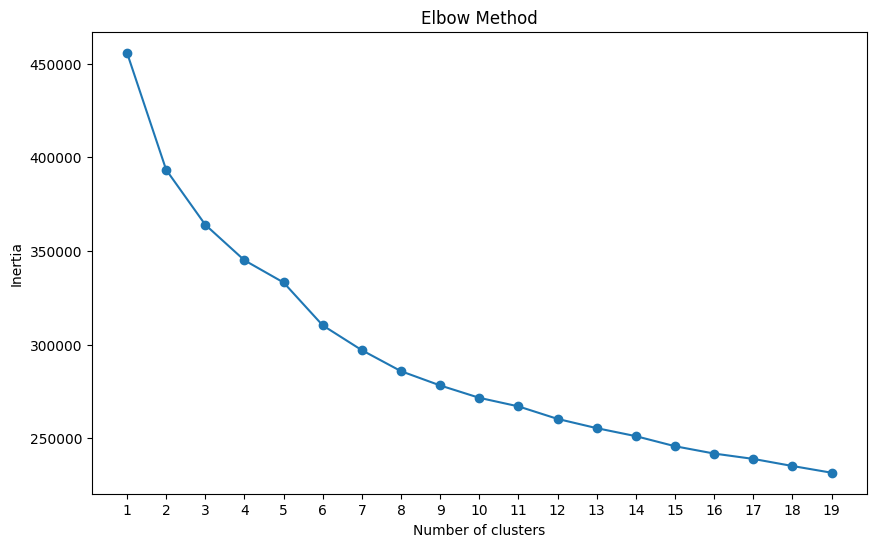

In [107]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(inverse_standard_normal_df)

# Applying the Elbow method to find the optimal number of clusters
inertia = []
range_of_clusters = range(1, 20)

for k in range_of_clusters:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range_of_clusters, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range_of_clusters)
plt.show()

num_of_cluster = 17

In [108]:
kmeans = KMeans(n_clusters=num_of_cluster, random_state=0)
kmeans.fit(inverse_standard_normal_df)
labels = kmeans.labels_
inverse_standard_normal_df['label'] = labels
inverse_standard_normal_df

,age_inv_cdf_stand,workclass_inv_cdf_stand,fnlwgt_inv_cdf_stand,education_inv_cdf_stand,marital_inv_cdf_stand,occupation_inv_cdf_stand,relationship_inv_cdf_stand,race_inv_cdf_stand,sex_inv_cdf_stand,gain_inv_cdf_stand,loss_inv_cdf_stand,hours_inv_cdf_stand,country_inv_cdf_stand,salary_inv_cdf_stand,label
0,0.030670,1.674014,-1.186195,0.243956,0.262252,-0.178637,0.133949,-0.010759,-0.553192,0.148451,-0.216656,-0.035429,0.555343,-0.947699,13
1,0.837096,0.856663,-1.094362,0.314971,-0.890124,-0.401244,-0.486795,-0.458811,-0.657357,-0.145918,-0.216656,-2.222119,-0.703666,-1.173124,7
2,-0.042641,-0.251544,0.404082,-0.476517,0.917702,1.335442,0.230094,-0.224615,-0.640464,-0.145918,-0.216656,-0.035429,-0.083429,-0.569220,2
3,1.057031,-1.037840,0.566885,0.943678,-0.843247,1.215321,-0.831695,1.842123,-0.559224,-0.145918,-0.216656,-0.035429,-1.360984,-0.170811,7
4,-0.775756,-0.205847,1.335040,0.295231,-0.849519,-1.644440,1.515843,1.783629,1.497027,-0.145918,-0.216656,-0.035429,2.548910,-0.673809,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.849067,-0.801477,0.749507,1.076369,-0.911714,1.669067,1.661126,-0.299330,1.067397,-0.145918,-0.216656,-0.197406,-0.062687,0.235264,8
32557,0.103982,-0.251174,-0.187890,-0.737841,-0.796547,0.636640,-0.753546,-0.056783,-0.477153,-0.145918,-0.216656,-0.035429,0.293549,1.889613,1
32558,1.423588,-0.758113,-0.214478,-1.172132,1.874824,-0.138743,1.407376,-1.130483,1.227224,-0.145918,-0.216656,-0.035429,0.289981,0.340613,15
32559,-1.215625,-1.363842,0.277496,-1.243036,0.293100,-0.185872,0.606417,0.215450,-0.544871,-0.145918,-0.216656,-1.655199,0.674748,0.030853,2


In [109]:
cluster_summary = inverse_standard_normal_df.groupby('label').agg(['mean', 'median', 'std'])

cluster_summary

age_inv_cdf_stand                     workclass_inv_cdf_stand            \
                   mean    median       std                    mean    median   
label                                                                           
0             -0.487352 -0.555822  0.664344               -0.618579 -0.615534   
1              0.339744  0.323916  0.709868               -0.609875 -0.599193   
2             -0.644122 -0.775756  0.657752               -0.600359 -0.610582   
3             -0.065411 -0.189264  0.723639               -0.517154 -0.585081   
4             -0.345555 -0.555822  0.856573               -0.250765 -0.497568   
5              0.493981  0.397227  0.808402                0.217868 -0.091899   
6              0.553713  0.543850  0.750340                1.436338  1.608112   
7              1.344968  1.423588  0.902964                0.870070  1.158490   
8             -1.193049 -1.362248  0.481740               -0.159178 -0.425626   
9              0.257929  0.250604  0.739399                0.162046 -0.170598   
10             0.188381  0.103982  0.839560               -0.115502 -0.381560   
11            -0.158826 -0.335887  0.943734               -0.043327 -0.366507   
12             0.543145  0.580506  0.844562                0.345250  0.014606   
13            -0.420557 -0.482510  0.743281                1.420990  1.451136   
14            -0.346688 -0.409199  0.761483               -0.040629 -0.387524   
15             1.592771  1.570211  0.681731                0.218190 -0.085057   
16             0.117224  0.030670  0.826299                0.586833  0.914258   

                fnlwgt_inv_cdf_stand                      \
            std                 mean    median       std   
label                                                      
0      0.446930            -0.016920  0.064810  0.969876   
1      0.436300             0.011031  0.048020  0.952815   
2      0.485037             0.085067  0.151168  0.997838   
3      0.620593            -0.038114  0.036448  0.975332   
4      0.868730             0.230547  0.216276  0.929386   
5      1.051018             0.021866  0.062069  0.940846   
6      0.397490            -0.007393  0.048030  1.018019   
7      0.840142            -0.131127 -0.039146  0.972987   
8      0.924975            -0.042257  0.036884  1.010868   
9      1.015614            -0.055029  0.020537  0.948221   
10     0.922826             0.317886  0.290798  0.951119   
11     0.980902            -0.099809 -0.016405  0.976010   
12     1.080351             0.001704 -0.006105  0.974442   
13     0.332329            -0.144843 -0.027583  1.035082   
14     0.993059             0.232716  0.224670  1.054625   
15     1.000190            -0.219201 -0.128425  0.943945   
16     0.901759            -0.513401 -0.348996  1.074224   

      education_inv_cdf_stand  ... loss_inv_cdf_stand hours_inv_cdf_stand  \
                         mean  ...                std                mean   
label                          ...                                          
0                   -0.196406  ...           0.076050            0.002491   
1                    0.097508  ...           0.000000            0.425375   
2                   -0.223197  ...           0.045544            0.048276   
3                   -0.299704  ...           0.000000            0.191604   
4                    0.324185  ...           0.076020           -0.220675   
5                    0.257774  ...           0.626012            0.525746   
6                    0.295383  ...           0.000000            0.428227   
7                    0.121010  ...           0.106528           -0.577109   
8                    0.294762  ...           0.000000           -1.850310   
9                    0.209694  ...           0.049517            0.008430   
10                   0.646405  ...           0.124446            0.196766   
11                  -0.020275  ...           0.756449           -0.165612   
12                   0.644809

In [110]:
inverse_standard_normal_df.iloc[:,0:14]

,age_inv_cdf_stand,workclass_inv_cdf_stand,fnlwgt_inv_cdf_stand,education_inv_cdf_stand,marital_inv_cdf_stand,occupation_inv_cdf_stand,relationship_inv_cdf_stand,race_inv_cdf_stand,sex_inv_cdf_stand,gain_inv_cdf_stand,loss_inv_cdf_stand,hours_inv_cdf_stand,country_inv_cdf_stand,salary_inv_cdf_stand
0,0.030670,1.674014,-1.186195,0.243956,0.262252,-0.178637,0.133949,-0.010759,-0.553192,0.148451,-0.216656,-0.035429,0.555343,-0.947699
1,0.837096,0.856663,-1.094362,0.314971,-0.890124,-0.401244,-0.486795,-0.458811,-0.657357,-0.145918,-0.216656,-2.222119,-0.703666,-1.173124
2,-0.042641,-0.251544,0.404082,-0.476517,0.917702,1.335442,0.230094,-0.224615,-0.640464,-0.145918,-0.216656,-0.035429,-0.083429,-0.569220
3,1.057031,-1.037840,0.566885,0.943678,-0.843247,1.215321,-0.831695,1.842123,-0.559224,-0.145918,-0.216656,-0.035429,-1.360984,-0.170811
4,-0.775756,-0.205847,1.335040,0.295231,-0.849519,-1.644440,1.515843,1.783629,1.497027,-0.145918,-0.216656,-0.035429,2.548910,-0.673809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.849067,-0.801477,0.749507,1.076369,-0.911714,1.669067,1.661126,-0.299330,1.067397,-0.145918,-0.216656,-0.197406,-0.062687,0.235264
32557,0.103982,-0.251174,-0.187890,-0.737841,-0.796547,0.636640,-0.753546,-0.056783,-0.477153,-0.145918,-0.216656,-0.035429,0.293549,1.889613
32558,1.423588,-0.758113,-0.214478,-1.172132,1.874824,-0.138743,1.407376,-1.130483,1.227224,-0.145918,-0.216656,-0.035429,0.289981,0.340613
32559,-1.215625,-1.363842,0.277496,-1.243036,0.293100,-0.185872,0.606417,0.215450,-0.544871,-0.145918,-0.216656,-1.655199,0.674748,0.030853


In [111]:
centroids = kmeans.cluster_centers_
centroids

array([[-4.87194413e-01, -6.18506483e-01, -1.75885107e-02,
        -1.96175862e-01,  5.96630020e-01, -6.03628174e-02,
         6.31638267e-01, -3.88282264e-01,  1.32046125e+00,
        -1.29928613e-01, -2.13056137e-01,  2.35234310e-03,
        -2.84404000e-01, -5.16871987e-01],
       [ 3.39744277e-01, -6.09874891e-01,  1.10314783e-02,
         9.75084398e-02, -6.50924892e-01, -3.60729316e-01,
        -7.73623611e-01, -2.30708185e-01, -6.39212098e-01,
         1.13758505e-01, -2.16656200e-01,  4.25375461e-01,
        -2.79641023e-01,  1.53738627e+00],
       [-6.44715432e-01, -5.99819034e-01,  8.52391539e-02,
        -2.23676099e-01,  5.46271852e-01,  1.64621997e-01,
         4.59881061e-01, -3.81494281e-01, -7.06073678e-01,
        -1.28811610e-01, -2.15576136e-01,  4.86277210e-02,
        -2.80114778e-01, -4.76287035e-01],
       [-6.53200023e-02, -5.16210640e-01, -3.86011262e-02,
        -3.00593773e-01, -7.71059378e-01, -6.28796148e-02,
        -8.55107495e-01, -2.06360249e-01, -6.

In [112]:
gmm = GaussianMixture(n_components=num_of_cluster, covariance_type='full', random_state=0)

gmm.means_init = centroids ## Initial the means to let the apply components on different cluster

gmm.fit(inverse_standard_normal_df.iloc[:,0:14])

GaussianMixture(means_init=array([[-4.87194413e-01, -6.18506483e-01, -1.75885107e-02,
        -1.96175862e-01,  5.96630020e-01, -6.03628174e-02,
         6.31638267e-01, -3.88282264e-01,  1.32046125e+00,
        -1.29928613e-01, -2.13056137e-01,  2.35234310e-03,
        -2.84404000e-01, -5.16871987e-01],
       [ 3.39744277e-01, -6.09874891e-01,  1.10314783e-02,
         9.75084398e-02, -6.50924892e-01, -3.60729316e-01,...
         5.35515392e-01, -8.81565847e-02,  1.06192901e+00,
        -1.02385282e-01, -2.10885725e-01, -6.65856485e-01,
        -1.87413154e-01, -4.41822918e-01],
       [ 1.17224433e-01,  5.86833136e-01, -5.13400630e-01,
        -1.51366605e-01, -2.50062550e-01,  6.48795059e-01,
        -4.28688700e-01, -1.83767810e-01, -5.59553560e-01,
        -1.00127820e-01, -2.12515189e-01,  2.47828670e+00,
        -1.18874155e-01, -1.03940914e-01]]),
                n_components=17, random_state=0)

In [113]:
inverse_standard_normal_df

,age_inv_cdf_stand,workclass_inv_cdf_stand,fnlwgt_inv_cdf_stand,education_inv_cdf_stand,marital_inv_cdf_stand,occupation_inv_cdf_stand,relationship_inv_cdf_stand,race_inv_cdf_stand,sex_inv_cdf_stand,gain_inv_cdf_stand,loss_inv_cdf_stand,hours_inv_cdf_stand,country_inv_cdf_stand,salary_inv_cdf_stand,label
0,0.030670,1.674014,-1.186195,0.243956,0.262252,-0.178637,0.133949,-0.010759,-0.553192,0.148451,-0.216656,-0.035429,0.555343,-0.947699,13
1,0.837096,0.856663,-1.094362,0.314971,-0.890124,-0.401244,-0.486795,-0.458811,-0.657357,-0.145918,-0.216656,-2.222119,-0.703666,-1.173124,7
2,-0.042641,-0.251544,0.404082,-0.476517,0.917702,1.335442,0.230094,-0.224615,-0.640464,-0.145918,-0.216656,-0.035429,-0.083429,-0.569220,2
3,1.057031,-1.037840,0.566885,0.943678,-0.843247,1.215321,-0.831695,1.842123,-0.559224,-0.145918,-0.216656,-0.035429,-1.360984,-0.170811,7
4,-0.775756,-0.205847,1.335040,0.295231,-0.849519,-1.644440,1.515843,1.783629,1.497027,-0.145918,-0.216656,-0.035429,2.548910,-0.673809,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.849067,-0.801477,0.749507,1.076369,-0.911714,1.669067,1.661126,-0.299330,1.067397,-0.145918,-0.216656,-0.197406,-0.062687,0.235264,8
32557,0.103982,-0.251174,-0.187890,-0.737841,-0.796547,0.636640,-0.753546,-0.056783,-0.477153,-0.145918,-0.216656,-0.035429,0.293549,1.889613,1
32558,1.423588,-0.758113,-0.214478,-1.172132,1.874824,-0.138743,1.407376,-1.130483,1.227224,-0.145918,-0.216656,-0.035429,0.289981,0.340613,15
32559,-1.215625,-1.363842,0.277496,-1.243036,0.293100,-0.185872,0.606417,0.215450,-0.544871,-0.145918,-0.216656,-1.655199,0.674748,0.030853,2


In [114]:
synthetic_overall = gmm.sample(len(inverse_standard_normal_df))[0]

column_names = ['age', ' workclass', ' fnlwgt', ' education', ' marital-status', ' occupation', ' relationship', ' race',
                                                             ' sex', ' capital-gain', ' capital-loss', ' hours-per-week', ' native-country', ' salary']
synthetic_overall_df = pd.DataFrame(synthetic_overall, columns=column_names)


synthetic_overall_df

covariance_matrix1 = synthetic_overall_df.cov() ##used for the comparison later

In [115]:
synthetic_overall_df

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,0.983591,0.925058,-1.876533,-0.302442,0.496412,1.061813,1.047683,1.097958,1.207172,-0.147101,-0.216221,0.364825,-0.954710,0.858900
1,0.375783,0.959234,1.269996,0.636939,1.605351,-0.194439,0.226201,1.273728,0.993595,-0.146462,-0.217242,0.333122,-0.091918,0.193964
2,-0.281900,-0.480654,0.074638,0.503655,0.687117,0.720316,0.586219,0.672914,1.200542,-0.146134,-0.217448,1.127795,-0.210418,-0.817271
3,-0.306524,1.091866,-1.576778,-1.039623,0.603338,0.608211,0.577765,0.403213,1.403563,-0.147075,-0.215832,-0.607746,0.315013,-1.476234
4,1.047616,-0.622653,0.140344,0.341083,0.635823,-1.058496,1.064599,2.522331,1.502713,-0.144921,-0.217070,1.188892,-0.253026,0.298869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.508633,0.004698,1.421924,-1.811569,2.576248,0.862444,0.989559,-1.144308,-0.333380,-0.145368,-0.218140,-1.381179,-0.492949,-0.725165
32557,0.422383,0.399464,0.033970,0.054873,-1.372417,2.241536,-0.668888,0.904947,-1.110312,-0.145024,-0.217172,0.899510,-0.367086,1.100438
32558,-1.534362,0.036880,2.144865,0.180053,0.703525,-0.094163,0.703299,-0.102645,-0.857556,-0.146781,-0.215760,-1.794334,-0.600232,-0.563394
32559,0.077709,-0.190872,-0.565150,0.021058,0.085745,1.321851,0.330361,0.888786,-0.114904,-0.144953,-0.216187,-0.609925,-0.052408,-1.109021


In [116]:
def inverse_cdf_age(p):
    """
    Calculates the inverse of the Cumulative Distribution Function (CDF) values 
    for a normal distribution.

    :param cdf_values: The CDF values (probabilities).
    :param data_mean: Mean of the original data used in CDF calculation.
    :param data_std: Standard deviation of the original data used in CDF calculation.
    :return: The original values corresponding to the given CDF values.
    """
    # Calculating the inverse CDF values using the normal distribution
    original_values = norm.ppf(p, loc=age_mean, scale=age_std)

    return original_values
def inverse_cdf_workclass(p):
    """
    Calculates the inverse of the Cumulative Distribution Function (CDF) values 
    for a normal distribution.

    :param cdf_values: The CDF values (probabilities).
    :param data_mean: Mean of the original data used in CDF calculation.
    :param data_std: Standard deviation of the original data used in CDF calculation.
    :return: The original values corresponding to the given CDF values.
    """
    # Calculating the inverse CDF values using the normal distribution
    original_values = norm.ppf(p, loc=workclass_mean, scale=workclass_std)

    return original_values

def inverse_cdf_fnlwgt(p):
    """
    Calculates the inverse of the Cumulative Distribution Function (CDF) values 
    for a beta distribution.

    :param cdf_values: The CDF values (probabilities).
    :param data_min: Minimum value of the original data.
    :param data_max: Maximum value of the original data.
    :param a, b: Parameters of the beta distribution (shape parameters).
    :param loc, scale: Location and scale parameters of the beta distribution.
    :return: The original values corresponding to the given CDF values.
    """
    # Calculating the inverse CDF (PPF) values
    normalized_values = beta.ppf(p, af, bf, locf, scalef)

    # Transforming the normalized values back to the original scale
    original_values = normalized_values * (maxf - minf) + minf

    return original_values

def inverse_cdf_education(p):
    
    min_value = min_value_education
    max_value = max_value_education
    scale = max_value - min_value

    return uniform.ppf(p, loc=min_value, scale=scale)


def inverse_cdf_marital(p):

    min_value = min_value_marital
    max_value = max_value_marital
    scale = max_value - min_value

    return uniform.ppf(p, loc=min_value, scale=scale)


def inverse_cdf_occupation(p):

    min_value = min_value_occupation
    max_value = max_value_occupation
    scale = max_value - min_value

    return uniform.ppf(p, loc=min_value, scale=scale)

def inverse_cdf_relationship(p):
    
    min_value = min_value_relationship
    max_value = max_value_relationship
    scale = max_value - min_value

    return uniform.ppf(p, loc=min_value, scale=scale)


def inverse_cdf_race(p):
    """
    Calculates the inverse of the Cumulative Distribution Function (CDF) values 
    for a normal distribution.

    :param cdf_values: The CDF values (probabilities).
    :param data_mean: Mean of the original data used in CDF calculation.
    :param data_std: Standard deviation of the original data used in CDF calculation.
    :return: The original values corresponding to the given CDF values.
    """
    # Calculating the inverse CDF values using the normal distribution
    original_values = norm.ppf(p, loc=race_mean, scale=race_std)

    return original_values


def inverse_cdf_sex(p):
    """
    Calculates the inverse of the Cumulative Distribution Function (CDF) values 
    for a normal distribution.

    :param cdf_values: The CDF values (probabilities).
    :param data_mean: Mean of the original data used in CDF calculation.
    :param data_std: Standard deviation of the original data used in CDF calculation.
    :return: The original values corresponding to the given CDF values.
    """
    # Calculating the inverse CDF values using the normal distribution
    original_values = norm.ppf(p, loc=sex_mean, scale=sex_std)

    return original_values


def inverse_cdf_gain(p):
    """
    Calculates the inverse of the Cumulative Distribution Function (CDF) values 
    for a normal distribution.

    :param cdf_values: The CDF values (probabilities).
    :param data_mean: Mean of the original data used in CDF calculation.
    :param data_std: Standard deviation of the original data used in CDF calculation.
    :return: The original values corresponding to the given CDF values.
    """
    # Calculating the inverse CDF values using the normal distribution
    original_values = norm.ppf(p, loc=gain_mean, scale=gain_std)

    return original_values


def inverse_cdf_loss(p):
    """
    Calculates the inverse of the Cumulative Distribution Function (CDF) values 
    for a normal distribution.

    :param cdf_values: The CDF values (probabilities).
    :param data_mean: Mean of the original data used in CDF calculation.
    :param data_std: Standard deviation of the original data used in CDF calculation.
    :return: The original values corresponding to the given CDF values.
    """
    # Calculating the inverse CDF values using the normal distribution
    original_values = norm.ppf(p, loc=loss_mean, scale=loss_std)

    return original_values


def inverse_cdf_hours(p):
    """
    Calculates the inverse of the Cumulative Distribution Function (CDF) values 
    for a normal distribution.

    :param cdf_values: The CDF values (probabilities).
    :param data_mean: Mean of the original data used in CDF calculation.
    :param data_std: Standard deviation of the original data used in CDF calculation.
    :return: The original values corresponding to the given CDF values.
    """
    # Calculating the inverse CDF values using the normal distribution
    original_values = norm.ppf(p, loc=hours_mean, scale=hours_std)

    return original_values


def inverse_cdf_country(p):
    
    mean = mean_country
    std = std_country
    low_std,upp_std = low_std_country,upp_std_country

    return truncnorm.ppf(p, low_std, upp_std, loc=mean, scale=std)


def inverse_cdf_salary(p):
    """
    Calculates the inverse of the Cumulative Distribution Function (CDF) values 
    for a normal distribution.

    :param cdf_values: The CDF values (probabilities).
    :param data_mean: Mean of the original data used in CDF calculation.
    :param data_std: Standard deviation of the original data used in CDF calculation.
    :return: The original values corresponding to the given CDF values.
    """
    # Calculating the inverse CDF values using the normal distribution
    original_values = norm.ppf(p, loc=salary_mean, scale=salary_std)

    return original_values


F_inv = [inverse_cdf_age, inverse_cdf_workclass, inverse_cdf_fnlwgt, inverse_cdf_education, inverse_cdf_marital, inverse_cdf_occupation, inverse_cdf_relationship, 
         inverse_cdf_race, inverse_cdf_sex, inverse_cdf_gain, inverse_cdf_loss, inverse_cdf_hours, inverse_cdf_country, inverse_cdf_salary]

In [117]:
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,0.924584,77516,0.596469,13,0.603484,0.429660,0.553051,0.497753,0.360040,2174,0,40,0.612306,0.270150
1,50,0.716789,83311,0.623699,13,0.186986,0.344759,0.313130,0.399358,0.333682,0,0,13,0.356840,0.215766
2,38,0.435049,215646,0.317058,9,0.820536,0.909171,0.590739,0.450789,0.337957,0,0,40,0.482573,0.361457
3,53,0.235149,234721,0.827348,7,0.199824,0.887938,0.202790,0.904653,0.358514,0,0,40,0.226617,0.457573
4,28,0.446666,338409,0.616185,13,0.198077,0.050995,0.934747,0.891808,0.878836,0,0,40,0.959278,0.336225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,0.295239,257302,0.859122,12,0.181250,0.952439,0.951172,0.434381,0.770120,0,0,38,0.486792,0.555539
32557,40,0.435143,154374,0.230543,9,0.213129,0.738040,0.225545,0.487645,0.379281,0,0,40,0.559220,0.954649
32558,58,0.306264,151910,0.120850,9,0.969429,0.445358,0.919878,0.251856,0.810563,0,0,40,0.558495,0.580954
32559,22,0.152269,201490,0.107210,9,0.615318,0.426824,0.727541,0.547429,0.362146,0,0,20,0.636434,0.506225


In [118]:
def sample(F_inv, Sigma):
    """
    Sample numerical values from the distribution and covariances of the columns.
    
    Parameters:
    - F_inv: A list of inverse CDF functions for the marginals.
    - Sigma: The covariance matrix.
    
    Returns:
    - A sample vector x in the original space.
    """
    # Step 2: Random n-dimensional Gaussian vector
    n = Sigma.shape[0]
    v = np.random.randn(n)
    
    # Step 3: Cholesky decomposition
    L = np.linalg.cholesky(Sigma)
    
    # Step 4: u ← Lv
    u = L.dot(v)
    
    # Step 5: x ← [F_0^(-1)(Φ(u_0)), F_1^(-1)(Φ(u_1)), ..., F_n^(-1)(Φ(u_n))]
    x = [F_inv_i(norm.cdf(u_i)) for F_inv_i, u_i in zip(F_inv, u)]
    
    return x




num_rows = data.shape[0]  # Number of rows you want to generate
synthetic_dataset = [sample(F_inv, covariance_matrix1) for _ in tqdm(range(num_rows))]
synthetic_df_full = pd.DataFrame(synthetic_dataset, columns=['age', ' workclass', ' fnlwgt', ' education', ' marital-status', ' occupation', ' relationship', ' race',
                                                             ' sex', ' capital-gain', ' capital-loss', ' hours-per-week', ' native-country', ' salary'])


100%|██████████| 32561/32561 [00:56<00:00, 578.37it/s]


In [119]:
synthetic_df_full

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39.408345,0.496101,51694.967251,0.444314,0.582051,0.985730,0.765174,0.138118,0.472233,-3351.922372,-539.681799,30.985011,0.449225,0.651386
1,58.234694,0.490032,236775.495963,0.874686,0.673150,0.994150,0.487328,0.614127,0.618001,-6836.098590,199.533698,28.704218,0.342580,0.320923
2,52.400170,0.432045,108984.752320,0.551748,0.239746,0.544125,0.334111,0.404595,0.446686,3499.813099,-413.886496,67.768029,0.283576,0.692052
3,28.195974,0.041224,433649.519015,0.389514,0.873325,0.414571,0.941859,0.485556,0.681371,-4235.396914,-824.930674,23.557213,0.990866,-0.071041
4,28.930519,0.054029,494266.938540,0.415401,0.772947,0.725834,0.875926,0.712310,0.431958,-166.959023,331.633712,17.699046,0.646928,0.384169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,24.442084,0.577848,208934.910093,0.684579,0.816785,0.985673,0.889163,0.905100,1.062827,1067.443111,-317.830377,50.803660,0.602862,0.359744
32557,22.459785,0.444599,201163.463622,0.101090,0.221603,0.442368,0.467294,0.654837,0.762698,-4510.126992,19.567929,24.328988,0.702039,0.430453
32558,37.919986,0.736209,181033.931337,0.859903,0.502130,0.232006,0.841835,0.897348,0.854542,7975.979786,-95.407326,19.772289,0.550972,0.765220
32559,37.483672,0.670708,213300.647486,0.275425,0.786440,0.389080,0.323950,0.552619,0.477348,-14.586577,-389.457834,35.474128,0.593196,0.015740


In [120]:
def numerical_to_category(num_value, category_intervals):
    """ Convert a numerical value back to its corresponding category. """
    for category, (a, b) in category_intervals.items():
        if a <= num_value < b:
            return category
        elif num_value > 1 and round(b) == 1:
            return category
        elif num_value < 0 and round(b) == 0:
            return category

In [121]:
inversed_categories_workclass = synthetic_df_full[' workclass'].apply(lambda x: numerical_to_category(x, category_intervals_workclass))
inversed_categories_education = synthetic_df_full[' education'].apply(lambda x: numerical_to_category(x, category_intervals_education))
inversed_categories_marital = synthetic_df_full[' marital-status'].apply(lambda x: numerical_to_category(x, category_intervals_marital))
inversed_categories_occupation = synthetic_df_full[' occupation'].apply(lambda x: numerical_to_category(x, category_intervals_occupation))
inversed_categories_relationship = synthetic_df_full[' relationship'].apply(lambda x: numerical_to_category(x, category_intervals_relationship))
inversed_categories_race = synthetic_df_full[' race'].apply(lambda x: numerical_to_category(x, category_intervals_race))
inversed_categories_sex = synthetic_df_full[' sex'].apply(lambda x: numerical_to_category(x, category_intervals_sex))
inversed_categories_country = synthetic_df_full[' native-country'].apply(lambda x: numerical_to_category(x, category_intervals_country))
inversed_categories_salary = synthetic_df_full[' salary'].apply(lambda x: numerical_to_category(x, category_intervals_salary))

In [122]:
synthetic_df_full[' workclass'] = inversed_categories_workclass

synthetic_df_full[' education'] = inversed_categories_education

synthetic_df_full[' marital-status'] = inversed_categories_marital

synthetic_df_full[' occupation'] = inversed_categories_occupation

synthetic_df_full[' relationship'] = inversed_categories_relationship

synthetic_df_full[' race'] = inversed_categories_race

synthetic_df_full[' sex'] = inversed_categories_sex

synthetic_df_full[' native-country'] = inversed_categories_country

synthetic_df_full[' salary'] = inversed_categories_salary

In [123]:
synthetic_df_full

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39.408345,Private,51694.967251,Some-college,Never-married,Protective-serv,Own-child,White,Male,-3351.922372,-539.681799,30.985011,United-States,<=50K
1,58.234694,Private,236775.495963,Assoc-acdm,Never-married,Protective-serv,Not-in-family,White,Male,-6836.098590,199.533698,28.704218,United-States,<=50K
2,52.400170,Private,108984.752320,Bachelors,Married-civ-spouse,Sales,Husband,White,Male,3499.813099,-413.886496,67.768029,United-States,<=50K
3,28.195974,Private,433649.519015,Some-college,Divorced,Adm-clerical,Wife,White,Female,-4235.396914,-824.930674,23.557213,Peru,None
4,28.930519,Private,494266.938540,Some-college,Never-married,Machine-op-inspct,Unmarried,White,Male,-166.959023,331.633712,17.699046,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,24.442084,Private,208934.910093,Bachelors,Divorced,Protective-serv,Unmarried,Black,Male,1067.443111,-317.830377,50.803660,United-States,<=50K
32557,22.459785,Private,201163.463622,HS-grad,Married-civ-spouse,Adm-clerical,Not-in-family,White,Female,-4510.126992,19.567929,24.328988,United-States,<=50K
32558,37.919986,Self-emp-not-inc,181033.931337,Assoc-acdm,Never-married,Craft-repair,Unmarried,Black,Female,7975.979786,-95.407326,19.772289,United-States,>50K
32559,37.483672,Private,213300.647486,HS-grad,Never-married,Adm-clerical,Husband,White,Male,-14.586577,-389.457834,35.474128,United-States,<=50K


In [128]:
data1 = pd.read_csv("American_Income.csv")

data_for_test = data1.drop(columns=[' education-num'])

In [129]:
data_for_test

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [130]:
metadata1 = SingleTableMetadata()
metadata1.detect_from_dataframe(data = data_for_test)
baseline_quality_report = evaluate_quality(
    data_for_test,  #real data
    synthetic_df_full, #synthetic data(perfect synthesizer generated(holdout))
    metadata1
)

Creating report: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]



Overall Quality Score: 81.65%

Properties:
Column Shapes: 85.47%
Column Pair Trends: 77.83%


In [131]:
metadata1 = SingleTableMetadata()

metadata1.detect_from_dataframe(data = data_for_test)
synthesier = GaussianCopulaSynthesizer(metadata1)
synthesier.fit(data_for_test)
synthetic_data = synthesier.sample(num_rows = num_rows)  #keep the number of rows equal to the data hold
synthetic_data 

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,44,Private,137738,HS-grad,Divorced,Transport-moving,Own-child,White,Female,87580,23,55,United-States,>50K
1,33,Federal-gov,144753,11th,Married-civ-spouse,Exec-managerial,Unmarried,White,Female,5255,0,60,United-States,<=50K
2,22,Private,263046,Prof-school,Married-civ-spouse,Transport-moving,Husband,White,Male,51338,0,49,United-States,>50K
3,47,Local-gov,142107,9th,Divorced,Prof-specialty,Own-child,Black,Female,49060,0,32,United-States,<=50K
4,24,Federal-gov,342515,Bachelors,Never-married,Transport-moving,Unmarried,Black,Male,3978,62,39,India,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,42,Federal-gov,74028,Masters,Married-spouse-absent,Transport-moving,Unmarried,White,Female,99592,0,38,United-States,<=50K
32557,21,Private,142426,Assoc-acdm,Never-married,Exec-managerial,Not-in-family,Black,Female,536,0,33,United-States,<=50K
32558,33,State-gov,106801,Masters,Never-married,Handlers-cleaners,Husband,White,Female,26961,0,24,United-States,<=50K
32559,49,?,148553,7th-8th,Married-civ-spouse,?,Own-child,White,Male,62266,112,39,Cuba,>50K


In [132]:
metadata1 = SingleTableMetadata()
metadata1.detect_from_dataframe(data = data_for_test)
baseline_quality_report = evaluate_quality(
    data_for_test,  #real data
    synthetic_data, #synthetic data(perfect synthesizer generated(holdout))
    metadata1
)

Creating report: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]



Overall Quality Score: 71.81%

Properties:
Column Shapes: 74.55%
Column Pair Trends: 69.07%
